Finish initialising class black_sea_obj


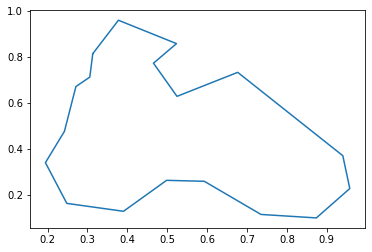

Finish initialising class black_sea_obj
Finish initialising class black_sea_obj


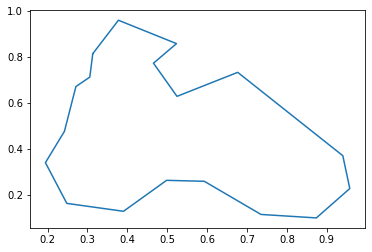

Finish initialising class black_sea_obj
Point is not on border. Define coordinates as POINT (0.2483661189101248 0.1631374527378108)
Point is not on border. Define coordinates as POINT (0.3777274107297386 0.9592183785623825)
Point is not on border. Define coordinates as POINT (0.2426371188874047 0.4781312724316756)
Point is not on border. Define coordinates as POINT (0.9575072937554686 0.2276474587960089)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #; sns.set_theme() # For heat map
from scipy.optimize import minimize # For automatic minimisation of the negative
# likelihood of the position
import numpy.random as rnd
from numpy.linalg import norm, inv
from numpy.random import randn
from numpy import dot
import matplotlib.path as mpltPath # to check if the point is on the border
from scipy.optimize import NonlinearConstraint
from ipynb.fs.full.class_virt_sensor import virt_sensor_net2
from ipynb.fs.full.class_ship import ship_fleet
from ipynb.fs.full.class_black_sea import black_sea_obj

from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
import functools

%run ./strand2_methods.ipynb
%run ./class_black_sea.ipynb

# Define black sea object
black_sea_coords = np.load('blackSea_polygon_coords.npy')
#plt.plot(black_sea_coords[:,0], black_sea_coords[:,1],'o')

black_sea = black_sea_obj(black_sea_coords)
black_sea.set_port('Istanbul', np.array([0,0]))
black_sea.set_port('Odessa', np.array([.4,1]))
black_sea.set_port('Varna', np.array([.23, .48]))
black_sea.set_port('Batumi', np.array([.97, .22]))



Finish initialising class black_sea_obj
Point is not on border. Define coordinates as POINT (0.2483661189101248 0.1631374527378108)
Point is not on border. Define coordinates as POINT (0.3777274107297386 0.9592183785623825)
Point is not on border. Define coordinates as POINT (0.2426371188874047 0.4781312724316756)
Point is not on border. Define coordinates as POINT (0.9575072937554686 0.2276474587960089)


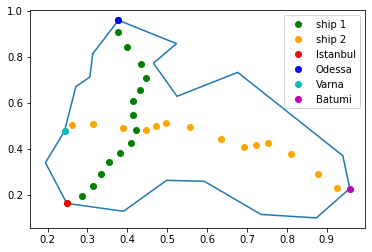

In [2]:
########################################################################
# STEP 0: DEFINE SOME INTERESTING PATHS
########################################################################


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #; sns.set_theme() # For heat map
from scipy.optimize import minimize # For automatic minimisation of the negative
# likelihood of the position
import numpy.random as rnd
import numpy.linalg as linalg
import matplotlib.path as mpltPath # to check if the point is on the border
from scipy.optimize import NonlinearConstraint


# PREPARATION: Set boundaries and ports

# Define black sea object
black_sea_coords = np.load('/Users/marcelstozir/Desktop/IRP_sensorOptimisation/actual_work/code/simulation_of_simplified_sound_measures/definition_of_black_sea_borders/blackSea_polygon_coords.npy')
#plt.plot(black_sea_coords[:,0], black_sea_coords[:,1],'o')

black_sea = black_sea_obj(black_sea_coords)
black_sea.set_port('Istanbul', np.array([0,0]))
black_sea.set_port('Odessa', np.array([.4,1]))
black_sea.set_port('Varna', np.array([.23, .48]))
black_sea.set_port('Batumi', np.array([.97, .22]))

# IDEA 1: Sine wave around curves

# For plane motions we need as underlying curve the polar coordinates
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi)

def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return(x, y)

def get_curve(start, stop, time_T):
    # Use polar coordinates where radius moves linear and angle moves quadratic
    # in the time component
    pol_coords_start = cart2pol(start[0], start[1])
    r_start = pol_coords_start[0]
    phi_start = pol_coords_start[1]
    pol_coords_stop = cart2pol(stop[0], stop[1])
    r_stop = pol_coords_stop[0]
    phi_stop = pol_coords_stop[1]
    
    r_dynamic = np.linspace(r_start, r_stop, num = time_T+1)
    
    # For quadratic formula of the angle define a point in the middle to make
    # it more extreme
    '''
    middle = cart2pol(.4, .65) #(phi_start + phi_stop)/2
    middle = middle[1]
    #middle =  middle - 1/4 * (middle - phi_start)
    #x = np.array([0, (time_T+1)/2, time_T+1])
    x = np.array([0, .75*(time_T+1), time_T+1])
    y = np.array([phi_start, middle, phi_stop])
    params = np.polyfit(x, y, deg = 2)
    phi_dynamic = params[2] + params[1]*np.arange(0, time_T+1) + params[0]*np.arange(0, time_T+1)**2
    '''
    phi_dynamic = np.linspace(phi_start, phi_stop, num = time_T+1)
    return(r_dynamic, phi_dynamic)
    




    
    
def get_wavy_data(start, stop, num_curves, amp_value, time_T):
    if (time_T % num_curves != 0):
        print("Time horizon needs to be multiple of number of curves")
        return()
    
    r_dynamic, phi_dynamic = get_curve(start, stop, time_T)
    sine_oscillation = - amp_value * np.sin(((3*2*np.pi)/time_T)*np.arange(0, time_T+1))
    
    phi_dynamic = phi_dynamic + sine_oscillation
    
    x_vals = np.zeros(time_T+1)
    y_vals = np.zeros(time_T+1)
    for i in range(time_T+1):
        x, y = pol2cart(r_dynamic[i], phi_dynamic[i])
        x_vals[i] = x
        y_vals[i] = y
    
    coords = np.array([x_vals, y_vals])
    coords = coords.T
    return(coords)
    
    
    

# TESTING: Curvy data


# PREPARATION: Set start and end points and number of curves in between (with 
# maximal amplitude); and number of points

pth_start_1 = black_sea.ports[0][1]
pth_end_1 = black_sea.ports[1][1]

pth_start_2 = black_sea.ports[3][1]
pth_end_2 = black_sea.ports[2][1]

num_curves = 3
amp_value = 0.025
amp_value_2 = 0.05
num_curves_2 = 3

T = 15 # NOTE: Needs to be a multiple of num_curves

coords_1 = get_wavy_data(pth_start_1, pth_end_1, num_curves, amp_value, T)
coords_2 = get_wavy_data(pth_start_2, pth_end_2, num_curves_2, amp_value_2, T)

ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.plot(coords_1[:,0], coords_1[:,1], 'og', label = "ship 1")
ax.plot(coords_2[:,0], coords_2[:,1], 'o', color = 'orange', label = "ship 2")
ax.plot(black_sea.ports[0][1][0], black_sea.ports[0][1][1], 'or', label = 'Istanbul')
ax.plot(black_sea.ports[1][1][0], black_sea.ports[1][1][1], 'ob', label = 'Odessa')
ax.plot(black_sea.ports[2][1][0], black_sea.ports[2][1][1], 'oc', label = 'Varna')
ax.plot(black_sea.ports[3][1][0], black_sea.ports[3][1][1], 'om', label = 'Batumi')
plt.legend(loc="upper right")


np.save('2_wavy_ship_paths.npy', [coords_1, coords_2], allow_pickle=True)

# load the two wavy ship path file via
# data = np.load('2_wavy_ship_paths.npy', allow_pickle=True)



In [3]:

########################################################################
# STEP 1: IMPLEMENTING ILS METHOD FOR SENSOR FUSION
########################################################################

# Based on:
# https://share.cocalc.com/share/7557a5ac1c870f1ec8f01271959b16b49df9d087/Kalman-and-Bayesian-Filters-in-Python/07-Kalman-Filter-Math.ipynb?viewer=share

# IMPORTANT NOTE:
# We still use the "Gaussian sphere" application of the individual distance
# measurements BUT use the iterated least squares method (ILM) to obtain
# the actual position instead of the MLE method
# NOTE: The author says that sensor fusion should not be done using the Kalman
# filter but rather ILM or other methods; specifically:
'''
This is far from a complete coverage of the iterated least squares algorithm, 
let alone methods used in GNSS to compute positions from GPS pseudoranges. 
You will find a number of approaches in the literature, including QR decomposition, 
SVD, and other techniques to solve the overdetermined system. For a nontrivial 
task you will have to survey the literature and perhaps design your algorithm 
depending on your specific sensor configuration, the amounts of noise, your 
accuracy requirements, and the amount of computation you can afford to do.
'''

# IMPORTANT TODO: Integrate the "get_range" into the sensor network CLASS and
# later combine the "meas_fun_ILS" and "pos_est_ILS" into a single "measurement_UKF"
# function for the UKF algorithm


def calc_ranges(ship_pos, sens_network_pos):
    '''
    Compute distance between ship position 'ship_pos' and the LIST of positions
    in sensor network positions 'sens_network_pos'
    '''
    ranges = norm(np.array(ship_pos) - sens_network_pos, axis = 1)
    return(ranges)


def meas_fun_ILS(ship_pos, sens_network_pos, range_est): # linearisation of 
# measure function H (as d(measure)/d(ship pos))
# NOTE: ship position will be iteratively determined (but is not known)
    N = len(sens_network_pos) # LATER: [sensor network].size
    sens_network_pos = np.asarray(sens_network_pos)
    H = np.zeros((N, 2))
    for j in range(N):
        H[j, 0] = (ship_pos[0] - sens_network_pos[j, 0]) / range_est[j] # approx.
        # derivative in x-measurement
        H[j, 1] = (ship_pos[1] - sens_network_pos[j, 1]) / range_est[j] # approx.
        # derivative in y-measurement
    return H

def pos_est_ILS(distort_ranges, sens_network_pos, init_pos_est, meas_fun_ILS, eps = 1e-8):
    '''
    Given a list of (distorted) range measurements 'distort_ranges' from the ship
    to each of the sensors (with positions in list sens_network_pos) and an 
    initial guess of the absolute position of the ship 'init_pos_est', this
    method uses the ILS method (based on the linearisation of the measure function
    'meas_fun_ILS') to iteratively estimate the absolute ship position until
    it does not change more than 'eps' from one iteration to the next
    '''
    pos = np.array(init_pos_est)
    
    #with book_format.numpy_precision(precision = 4):
    converged = False
    for i in range(30): # Safety break: No more than 30 iterations
        range_est = calc_ranges(pos, sens_network_pos)
        #print('Iteration:', i)
            
        y = distort_ranges - range_est # 'innovation' or change to initial measurements
        #print('Innovation:', y)
            
        H = meas_fun_ILS(pos, sens_network_pos, range_est)
        H_inv = inv(dot(H.T, H)).dot(H.T) 
        H_y = np.dot(H_inv, y) # OLS estimate for y = H x
        
        # Update step
        pos = pos + H_y
        #print('position: {}\n\n'.format(pos))
            
        if max(abs(H_y)) < eps:
            converged = True
            break
            
    return pos, converged

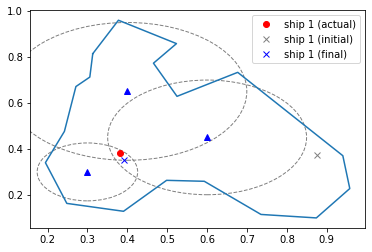

In [4]:

########################################################################
# TESTING ILS METHOD
########################################################################


# FOLLOWING FUNCTIONS SHOULD BE USED AS INITIAL GUESS
def sound_prop_error(range_vec, error_scale): # CURRENTLY: logarithmic normal
# distortion based on sound propagation formulat 
# NEXT VERSION: Without any simulated error by solely basing it on the ICA estimates
# (which should have (possibly systematic/correlated) normal error)
    N = len(range_vec)
    log_dist_scale = error_scale * np.log(1 + range_vec) # NOTE: +1 to ensure positivity
    errs = np.random.normal(0, 1, N) * log_dist_scale
    distort_range = range_vec + errs
    return(distort_range)


def get_distort_ranges(ship_pos, sens_network_pos, error_scale):
    '''
    Distorted range measurements for initial value
    '''
    ranges = norm(np.array(ship_pos) - sens_network_pos, axis = 1)
    distort_ranges = sound_prop_error(ranges, error_scale)
    return(distort_ranges)



# load the two wavy ship path file
data = np.load('2_wavy_ship_paths.npy', allow_pickle=True)

ship_1_coords = data[0]
ship_2_coords = data[1]

test_position = ship_1_coords[5,:]
sens_network_pos = [[.3, .3], [.6, .45], [.4, .65]]
error_scale = .1

distort_ranges = get_distort_ranges(test_position, sens_network_pos, error_scale)

# For initial guess choose a random point within the boundary
init_pos_est = []
accepted = False
while not(accepted):
    init_cand = np.random.uniform(0, 1, 2)
    path = mpltPath.Path(black_sea.border_points)
    
    tf_value = path.contains_point(init_cand)
    if tf_value:
        init_pos_est = init_cand
        accepted = True

eps = 1e-8
pos, converged = pos_est_ILS(distort_ranges, sens_network_pos, init_pos_est, meas_fun_ILS, eps)

ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.plot(test_position[0], test_position[1], 'or', label = "ship 1 (actual)")
for i in range(len(sens_network_pos)):
    sensor = sens_network_pos[i]
    rnge = distort_ranges[i]
    ax.plot(sensor[0], sensor[1], '^b')
    circ = plt.Circle(sensor, radius=rnge, linestyle='--',color = 'gray', fill = False)
    ax.add_artist(circ)
ax.plot(init_pos_est[0], init_pos_est[1], 'x', color = 'gray', label = "ship 1 (initial)")
ax.plot(pos[0], pos[1], 'xb', label = "ship 1 (final)")
'''
ax.plot(coords_1[:,0], coords_1[:,1], 'og', label = "ship 1")
ax.plot(coords_2[:,0], coords_2[:,1], 'o', color = 'orange', label = "ship 2")
ax.plot(black_sea.ports[0][1][0], black_sea.ports[0][1][1], 'or', label = 'Istanbul')
ax.plot(black_sea.ports[1][1][0], black_sea.ports[1][1][1], 'ob', label = 'Odessa')
ax.plot(black_sea.ports[2][1][0], black_sea.ports[2][1][1], 'oc', label = 'Varna')
ax.plot(black_sea.ports[3][1][0], black_sea.ports[3][1][1], 'om', label = 'Batumi')
'''
plt.legend(loc="upper right")

In [5]:

class UKF_args():
    def __init__(self, error_scale, sens_network_pos):
        self.error_scale = error_scale
        self.sens_network_pos = sens_network_pos
        

def get_random_init_pos():
    init_pos_est = []
    accepted = False
    while not(accepted):
        init_cand = np.random.uniform(0, 1, 2)
        path = mpltPath.Path(black_sea.border_points)
    
        tf_value = path.contains_point(init_cand)
        if tf_value:
            init_pos_est = init_cand
            accepted = True
    return init_pos_est


def measurement(ship_pos, sens_network_pos, error_scale, initial_pos):
    '''
    The UKF measurement function will take the sensor network positions and the
    actual ship position at this time, then produces distorted range measurements
    according to "get_distort_ranges" which will then be fused (i.e. sensor fusion)
    by the ILS method "pos_est_ILS" into a position estimate (where the initial position
    "initial_pos" is chosen to be the last known/estimated position later on)
    '''
    distort_ranges = get_distort_ranges(ship_pos, sens_network_pos, error_scale)
    pos, converged = pos_est_ILS(distort_ranges, sens_network_pos, initial_pos, meas_fun_ILS, eps = 1e-8)
    return pos


def state_dynamic_step(x, dt):
    '''
    Constant velocity iteration for x = [x dx y dy] and state transition matrix
    F = [[1 dt 0 0],
         [0 0 1 0],
         [0 0 1 dt],
         [0 0 0 1]]
    '''
    x[0] += x[1]
    x[2] += x[3]
    return x


def measurement_function_wrapper(args, x):
    '''
    Assuming that the sensors can only pick up the position of the ship and
    not it's velocity, i.e. we have the measurement matrix (or linear function)
    H = [[1 0 0 0],
         [0 0 1 0]]

    '''
    
    error_scale = args.error_scale
    sens_network_pos = args.sens_network_pos
    # IMPORTANT NOTE: Unless we add arguments to the "hx" function in UKF:
    # We CANNOT choose the initial ship position as the last one
    # CURRENT VERSION: Random initial guess
    init_pos = get_random_init_pos()
    pos = [x[0], x[2]]
    # BIG PROBLEM: Cannot change the sensor network positions 
    return measurement(pos, sens_network_pos, error_scale, init_pos)



def moving_target_filter(target_pos, sens_network_pos, std_noise, Q, dt=1, kappa=0.0):
    '''
    UKF filtered object with "Merwe's scaled sigma points" and automated white
    noise
    '''
    # IMPORTANT: Play around with these parameters/understand what they do
    points = MerweScaledSigmaPoints(n = 4, alpha = .1, beta = 2., kappa = kappa) 
    
    
    # Define the actual measurement function that can only depend on a single x
    error_scale = 0 # TEST if this is still needed if we choose the automated white
    # noise machine
    sens_network_pos = sens_network_pos

    args = UKF_args(error_scale, sens_network_pos)
    
    measurement_function = functools.partial(measurement_function_wrapper, args)

    N = len(sens_network_pos)
    
    f = UKF(dim_x = 4, dim_z = 1, dt = dt, hx = measurement_function, 
            fx = state_dynamic_step, points = points)
    f.x = np.array([target_pos[0], 1., target_pos[1], 1.])

    q = Q_discrete_white_noise(2, dt, Q)
    f.Q[0:2, 0:2] = q # process noise matrix
    f.Q[2:4, 2:4] = q

    f.R *= std_noise**2 # measurement noise matrix
    f.P *= 1 # state covariance estimate matrix
    
    return f
# IMPORTANT: Test if Q_discrete_white_noise does exactly the same as "get_distor_ranges"


def track_nonlinear_moving_ship(ukf, error_scale, ship_lane, sens_network_pos):
    pred_path_vel = []
    measured_path = []
    time_horizon = len(ship_lane)
    
    for i in range(time_horizon):
        target_pos = ship_lane[i]
        # NOTE: We fix the starting value as a "this ship left this port"
        if i == 0:
            distort_pos = target_pos
            last_pos = target_pos
        else:
            distort_pos = measurement(target_pos, sens_network_pos, error_scale,
                                     last_pos)
            
        measured_path.append(distort_pos)
        ukf.predict()
        ukf.update(distort_pos)
        pred_path_vel.append(ukf.x)
        last_pos = [ukf.x[0], ukf.x[2]]
    
    pred_path_vel = np.asarray(pred_path_vel)    
    pred_path = pred_path_vel[:, [0,2]] # only take the filtered positions
    measured_path = np.asarray(measured_path)
    
    # OUTPUT
    plt.figure()
    ax = plt.gcf().gca()
    ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
    ax.plot(black_sea.ports[0][1][0], black_sea.ports[0][1][1], 'or', label = 'Istanbul')
    ax.plot(black_sea.ports[1][1][0], black_sea.ports[1][1][1], 'ob', label = 'Odessa')
    ax.plot(black_sea.ports[2][1][0], black_sea.ports[2][1][1], 'oc', label = 'Varna')
    ax.plot(black_sea.ports[3][1][0], black_sea.ports[3][1][1], 'om', label = 'Batumi')
    for sensor in sens_network_pos:
        ax.plot(sensor[0], sensor[1], '^b')
    ax.plot(pred_path[:, 0], pred_path[:, 1], 'x', color = 'g', label = "ship (filtered)")
    ax.plot(ship_lane[:, 0], ship_lane[:, 1], '-.b', label = "ship (actual)")
    ax.plot(measured_path[:, 0], measured_path[:, 1], 'x', color = 'gray', label = 'ship (measured)')
    plt.legend(loc="upper right")
    

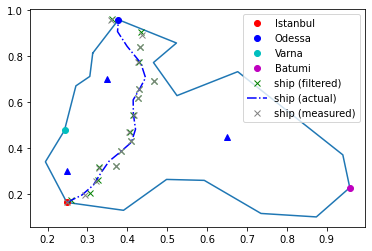

In [7]:
    
########################################################################
# TESTING IMPLEMENTATION: Unscented Kalman Filter on wavy ship lane
########################################################################


# load the two wavy ship path file
data = np.load('2_wavy_ship_paths.npy', allow_pickle=True)

ship_1_coords = data[0]
ship_2_coords = data[1]

sens_network_pos = [[.25, .3], [.65, .45], [.35, .7]]
  
std_noise = .1 #.1
error_scale = .05 #.1
target_pos = ship_1_coords[0,:]
f = moving_target_filter(target_pos, sens_network_pos, std_noise, Q = .1)
                         
track_nonlinear_moving_ship(f, error_scale, ship_1_coords, sens_network_pos) 



# BIG PROBLEM: ILS method does not adhere to borders => back to MLE estimate under
# boundary constraints